In [2]:
import pandas as pd
import re
import pytz
import pandas as pd
from collections import Counter


In [3]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1



In [4]:
# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])



In [5]:
def convert_utc_to_cet(df, date_column='date'):
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df

data = convert_utc_to_cet(data)

In [6]:
seventvlis = ['arnoldHalt',
 'SEXO',
 'peepoMarch',
 'doroHEAD',
 '4stars',
 'Rizzler',
 'ppL',
 'WAIT',
 'SpeedLaugh',
 'GetALoadOfThisGuy',
 'ModAbuse',
 'DoroCheer',
 'BHOP',
 'WhoAsked',
 'SCRAPETHATSHITJOHNNY',
 'OverwhelminglyWholesome',
 'SAJ',
 'NOW',
 'LETSFUCKINGJOE',
 '3stars',
 'aga',
 'ome47',
 'OMEGALUL',
 'Gayge',
 'peepoFat',
 'HolyFuck',
 'RAHH',
 'SNIFFA',
 'xdd',
 'EDGE',
 'LetsBingo',
 '!lurk',
 'Caught',
 'monakS',
 'ahmadmuhsin',
 'wade',
 'parasocial',
 'EdwardStare',
 'ISeeYou',
 'YouWouldntGetIt',
 'Banties',
 'DRAIN',
 'banties',
 'PepeHands',
 'WidelebronJAM',
 'Lamonting',
 'CAUGHT',
 'LOL',
 'FeelsDankMan',
 'pepeJAM',
 'ayo',
 '!unfollow',
 'glorp',
 'Waiting',
 'owoshy',
 'wideduckass',
 'HELLO',
 'Pepega',
 'DeathIncoming',
 'brbToilet',
 'ads',
 'despair',
 'TWEAK',
 'sus',
 'THINKING',
 'bruv',
 'ROFL',
 'juh',
 'skip',
 'OuttaPocket',
 'RareParrot',
 'emergencylandingstrip',
 'FirstTimePepega',
 'WideCatGroove',
 'Clueless',
 'ADHD',
 'StoryTime',
 'Delusional',
 'firewriting',
 'ragebait',
 'Aloo',
 'ome15',
 'peepoHug',
 'PagMan',
 'Based',
 'OMFG',
 'PepegaAim',
 'VeryPog',
 'OVERWORKING',
 'LL',
 'myIQ',
 'doroFiddy',
 'MUGA',
 'SAVEME',
 'GotEEM',
 'PagChomp',
 'Surfing',
 'PokiShare',
 'FEINFEINFEINFEINFEINFEINFEINFEI',
 'FeelsLagMan',
 'flowerr',
 'speed1',
 'NAUR',
 'BINGO',
 'STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE',
 'gothKiss',
 'WAYTOODANK',
 'ppOverheat',
 'ManchesterUnited',
 'dogJAM',
 'ewphop',
 'fortnite',
 'Doc1v1',
 'GotCaughtTrolling',
 'nonono',
 'dash',
 'veryDoro',
 'YAPPING',
 '!boost',
 'Bleh',
 'Sadge',
 'GIGAMOD',
 'dudWhat',
 'gPls',
 'YANITED',
 'Alarm',
 'WHOAAA',
 'HOLY',
 'TheVoices',
 'PokiShareW',
 'SpeedR',
 'RoxyPotato',
 'STREAMER',
 'emo2',
 'WatchingStream',
 'POVbornbefore2000',
 'lemon',
 'RaveTime',
 'dome44',
 'shutup',
 'ome55',
 'gg',
 'typeshit',
 'peepoLeave',
 'Paul',
 'unibrow',
 'GRRR',
 'lebronArrive',
 'DoroTalkingAgain',
 'ome29',
 'CrayonTime',
 'ANOTHERONE',
 'saythatagain',
 'monkaW',
 'peepoHey',
 'ONEMORE',
 'Considering',
 'Explosion',
 'LULE',
 'peepoKiss',
 'Joel',
 'CLOWNDETECTED',
 'ChillGuy',
 'Exerpas',
 'walterShocked',
 'ohneFinger',
 'SteerR',
 'lebronJAM',
 '+1',
 'EZdodge',
 'CLEAN',
 'ogo',
 'yesbro',
 'BantiesPaulBeef',
 'WalterVibe',
 'SOYSCREAM',
 'Pffttt',
 'WW',
 'VeryKey',
 'ome14',
 'spongePls',
 'Bello',
 'bieberDougie',
 'MODDING',
 ':tf:',
 'heyywithrizz',
 'HowDoWeTellHer',
 'sdd',
 'plinkVibe',
 'omeClap',
 'xJAM',
 'RussiaPls',
 'DRAMA',
 'firsttimebuh',
 'AINTNOWAY',
 'BUSSIN',
 'TriJam',
 'Modding',
 'WePaid',
 'Loading',
 'wideSpeedLaugh3',
 'ome104',
 'goblin44',
 'CaughtIn4K',
 'omEE',
 '0pixel',
 'arthur',
 'xqcL',
 'Borfday',
 'jacob3',
 '4Weird',
 'bah',
 'RealForsen',
 'BOOBA',
 'doroMAD',
 '5Head',
 'xqcTwerk',
 'Ohh',
 'peepoDJ',
 'HeDisconnected',
 'SCHEISSE',
 'scawy',
 'hi',
 'Drake',
 'RIPBOZO',
 'GAMBA',
 'RightThere',
 'JermaSoy',
 'wig',
 'WHOLETHERSLAY',
 'RAGEY',
 'peepoShy',
 'AIWITHTHEBRAIDS',
 'lurkk',
 'PepegaChat',
 'YeahThatsWhatIWouldaDid',
 'catDespair',
 'FellOff',
 'WIDEALERT',
 'Plotge',
 'mods',
 'Parasocial',
 'WakeTheFuckUpSamuraiWeHaveACityToBurn',
 'brb',
 'hackingCD',
 'luton',
 'heh',
 'BELIEVERS',
 'mhm',
 'Flirt',
 'PTSD',
 'LieMeter',
 'THIS',
 'uuh',
 'doroGHOST',
 'niceguy',
 'TriSad',
 'catSigh',
 'RememberTheDays',
 'OLDWORK',
 '(7TV)',
 'LookUp',
 'weirdChamp',
 'peepoTalk',
 'helvete',
 'EDITING',
 'OVERWATCH',
 'JESSE',
 'amongE',
 'COMEHERE',
 'MeRN',
 'emo',
 'Chatting',
 'goaler',
 'catJAM',
 'biteof87',
 'winton',
 'Looking',
 'om',
 'TRUEING',
 'peepoHappy',
 'VIDEOGAME',
 'justinbieber',
 'pickle',
 'SurE',
 'SLAY',
 'YAAY',
 'merch',
 'unmod',
 'GULP',
 'reckH',
 '5stars',
 'NoMaidens',
 'pepeW',
 'Sippin',
 'totallylistening',
 'WaitingForLove',
 'BANGER',
 'D:',
 'Dave',
 'WAHHH',
 'PepegaReading',
 'Steve',
 'forsenPls',
 'dome32',
 'OMEYES',
 'Jammies',
 'Listening',
 'GlorpMeeting',
 'glorprave',
 ':33',
 'BatChestAbove',
 'sisyphus',
 'BORGIR',
 'peepoPride',
 'NOIDONTTHINKSO',
 'INTENSEGAMING',
 '!drop',
 'lore',
 'NAHHHH',
 'phpk',
 'ImtiredBoss',
 'oopsie',
 'ok',
 'MAJ',
 'KKalinka',
 'FeelsWeirdMan',
 'NAvsEU',
 'ome101',
 '3Heading',
 'vibePls',
 'GoodTake',
 'ome105',
 'Yooo',
 'ome99',
 'omeStare',
 'LastTimeChatter',
 'Cinema',
 'HARAM',
 'Devious',
 'WideRaveTime',
 'Yoink',
 'AAAAAAAAUHGGH',
 'StreamEnding',
 'Johnporkiscalling',
 'SCHIZO',
 'FirstTimeChatter',
 'Waddup',
 'catBusiness',
 'modCheck',
 'FeelsStrongMan',
 'CatTime',
 'PianoTime',
 'FLASHBANG',
 'OOOO',
 'Susge',
 'nuhuh',
 'SUSSY',
 'NAILSING',
 'classic',
 'deadassFaint',
 'chatters',
 'ome44',
 'HABIBI',
 'ryanArrive',
 'joever',
 'Cuck',
 'pepeGun',
 'midloud',
 'LOCKIN',
 'ome32',
 'FARMING',
 'Scared',
 'matSad',
 'BEGGING',
 'GotCaughtCheating',
 'poroPls',
 'PepePls',
 'Sits',
 'sotruebestie',
 'Tuckge',
 'onggang',
 'widetime',
 'vas',
 'OneGuy',
 'HELP',
 'gkeywide',
 'life',
 'freddy',
 'GoodBye',
 'ome69',
 'AAAA',
 'AURA',
 'omeJudging',
 'doggoSlava',
 'GIGACHAIR',
 'pKitten',
 'SADge',
 'MYLIFE',
 'YouGotMe',
 'buhFlipExplode',
 'peepoSmile',
 'ome18',
 'glorpdetective',
 'Flushed',
 'Reacting',
 'peepoSad',
 'agahi',
 'AlienPls',
 'MODS',
 'characterSelected',
 'PotFriendDance',
 'Hmm',
 'MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse',
 'FUNNY',
 'Barry63',
 'forsenCD',
 'SpeedL',
 'Jay',
 'GOONING',
 'gkitten',
 'omeJAM',
 'FeelsLateMan',
 'wot',
 'bog',
 'WideHUH',
 '1star',
 'MeWhenIBuyEgyptianProperty',
 'xqc32',
 'smh',
 'Pipege',
 'SERIOUSLY',
 ':3',
 'doroKick',
 'peepoRiot',
 'Whenyourinnerwolfreleases',
 'nanaAYAYA',
 'catSmash',
 'catKISS',
 'RIRI',
 'SCORN',
 'IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH',
 'happi',
 'KEKW',
 'jacob2',
 'NAHH',
 'NOCHECKMARKS',
 'YESS',
 'buh',
 'EZ',
 'POLICE',
 'BaileyChamp',
 'peepoDoubters',
 'WeDoNotCare',
 'cokeBreak',
 'peepoComfy',
 'doroJAM',
 'ReallyMad',
 'ohhh',
 'KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat',
 'pepeAgony',
 'xqcDespair',
 'bye',
 'WineTime',
 'test',
 'IFISPEAK',
 'HUH',
 'LittleTrolling',
 'axeIF',
 'GIGACLAUS',
 'Staring',
 'ratio',
 'unemployment',
 '44emo',
 'notxqcL',
 'barack',
 'imback',
 'itsover',
 'LiterallyMe',
 'Pointless',
 'BUSSERS',
 'Broadcaster',
 'catTwerk',
 'KanyeStare',
 'peepoLegs',
 'Dentge',
 'Peace',
 'Reddit',
 'Panam',
 'drooling',
 'NOSHOT',
 'EldenRoll',
 'LiveReaction',
 'LETHERCOOK',
 'iDrive',
 'Gooner',
 'JokerHAHA',
 'LETSGO',
 'okak',
 'DOCBOZO',
 'MARIO',
 'Clap2',
 'ome41',
 'PARASOCIAL',
 'GODDID',
 'YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE',
 'Shruge',
 'MicTime',
 'WasZumPenis',
 'VibePls',
 'docAwaken',
 'batPls',
 'homelessPOV',
 'plonk',
 'UltraMad',
 'noonecares',
 'Tomfoolery',
 'COPIUM',
 'DrDisrespect',
 'Please',
 'FeelsGladMan',
 'ome96',
 'MONKE',
 'PAUSENEMOGU',
 'essaying',
 'WHOLETHERCOOK',
 'ratomilton',
 'ohno',
 'Prayge',
 'freakbob',
 'Madge',
 'peepoEvil',
 'WAJAJA',
 'hue',
 'xqcGoofy',
 'BigD',
 'ThePaulers',
 'EEK',
 'freakyfredday',
 'wallE',
 'JumpScared',
 'GENIUS',
 'WidezyzzPls',
 '!play',
 'KENOUGH',
 'DogLookingWickedAndCool',
 'raid',
 'Clown',
 'TriKool',
 'FINALLY',
 'zyzzJAM',
 'o7',
 'Batman',
 'Dime',
 'qq',
 'iAsked',
 'OMEGALULiguess',
 'CLIPPERS',
 'ApuApustaja',
 'HandsUp',
 'fnaf',
 'MEGALUL',
 'Wisdom',
 'Swag',
 'Enough',
 'girlBoss',
 'MONKA',
 'gooner',
 'giancarlo',
 'Noppers',
 'ZhongXina',
 'lockedin',
 'AlienDance',
 'Cyat',
 'peepoBelievers',
 'peepoClap',
 'Gaught',
 'catPls',
 'CS2',
 'VIEWERS',
 'JustAChillGuy',
 'GAGAGA',
 'omE',
 'ome52',
 'FristTime',
 ':0',
 'BOOM',
 'Stare',
 'chilling',
 'notListening',
 'Thinking',
 'NOTED',
 'YOOOLOOKATTHISCOCKWITHDADRIPSHII',
 'nymnCorn',
 'Ant',
 'barryArrive',
 'UGH',
 '2stars',
 'JARVIS',
 'gigl',
 'CatEat',
 'xqcBOZO',
 '1DLove',
 '!join',
 'jah',
 'KKonaW',
 'ThisChat',
 'WDYM',
 'RainTime',
 'AWOO',
 'batman',
 'KKool',
 'OHMYGAWDD',
 'LULW',
 'Clap',
 'fein',
 'WELSH',
 'otag',
 'Chillin',
 'spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123',
 'peepoGiggles',
 'War',
 'nt',
 'YamesBond',
 'crabPls',
 'GAMING',
 'BASED',
 'catAsk',
 'forsenLaughingAtYou',
 'OMEGADANCE',
 'pleading',
 '3Head',
 'Evilge',
 'FeelsBlackScreen',
 'GYAT',
 'AreYouSeriousRightNeow',
 'GIGACHAD',
 'silliness',
 'HowDoWeTellHim',
 'ANGRE',
 'MYMAINGOAL',
 'pL',
 'PEEPEES',
 'Dorozea',
 'zyzzBass',
 'FeelsOkayMan',
 'doroAunt',
 'YOUDIED',
 'steve',
 'Bloons',
 '1984',
 'xQcVeryWide',
 'FirstTimeBackseating',
 'xqcScHIZO',
 'pepePoint',
 'PogU',
 'ome4',
 'drukiDnace',
 'CoolMonkey',
 'doroBiceps',
 'ome79',
 'HECOOKING',
 'VALORANT',
 'peepoFarmer',
 'eww',
 'PepoG',
 'waa',
 'Bedge',
 'TRIVSsorry',
 'ThisIsMinecraft',
 'susDog',
 'GivenUp',
 'wrapitup',
 'itstime',
 'IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET',
 'GameplayTime',
 'SCAMMED',
 'Celebrating',
 'vibeeparty',
 'Smoge',
 'MoneyRain',
 'ICANT',
 'FeelsTiredMan',
 'FeelsWowMan',
 'donoWall',
 'me:',
 'HAH',
 'KeyShaker',
 'WeGood',
 'gachiGASM',
 'peepoAds',
 'FirstTimeTest',
 'ome21',
 'Gogging',
 '1Directioning',
 'GROOTING',
 'squadHips',
 'monkaTOS',
 'hiiii',
 'Belling',
 'docnotL',
 'PauseMan',
 'DespairRyan',
 'RebeccaBlack',
 'owoCheer',
 'MVPFarallah',
 'AlienPls3',
 'doroL',
 'Shits',
 'gachiBASS',
 'AYAYA',
 'Heisenberj',
 'MVP',
 'mikuPLS',
 'Headbang',
 'WeAreLive',
 'speed44',
 'FeelsBadMan',
 'EDM',
 'AwHellNah',
 'PagBounce',
 'Aware',
 'PartyParrot',
 'DemonTiming',
 'doroCD',
 'paul',
 'WHATAFUCKEDUPDAY',
 'Lithuanian',
 'WideHardo',
 'jacob4',
 'pokiFlirt',
 'Beatles',
 'HUHHHHHHHHHH',
 'Voices',
 'wideDvaAss',
 'waltuh',
 'BillyApprove',
 'PETPET',
 'DIESOFCRINGE',
 'ta',
 'Mog',
 'damily',
 'Adge',
 'ppHop',
 'HACKERMANS',
 'HarryStylesKiss',
 'Damn',
 'Nerd',
 'GuitarTime',
 'TeamEDWARD',
 'Thinking2',
 'ACTINUP',
 'JokerLaugh',
 'HEYYY',
 'XDoubt',
 'popipopipipopipo',
 'fadedthanaho',
 'BRUHMM',
 'ImNotOk',
 'Alfred',
 'AREYOUAGIRL',
 'glizzyoverdrive',
 'Jackass',
 'dreamwastaken',
 'woah',
 'hesRight',
 'YEP',
 'ome57',
 'CHADDING',
 'Cooked',
 'doid',
 'WAITWAITWAIT',
 'JustHowItIs',
 'speed25',
 'mutted',
 'xqcFuel',
 'widemonkaGIGAftRobertDowneyJr',
 'waiting',
 'BibleThump',
 'dimacut',
 'FiddyWtf',
 'AWOOGA',
 'MathTime',
 'SNACKING',
 'gamily',
 'PepeLaugh',
 'Smile',
 'FirstTimeome44',
 'TITANHOLO',
 'WHAT',
 'Alright',
 'BOOMIES',
 'Deadass',
 'NOWAYING',
 'BasedGod',
 'phew',
 'Memories',
 'Ignored',
 'CatCozy',
 'greetingsladies',
 'xar2EDM',
 'DOUBTERS',
 'SCATTER',
 'Sadding',
 'ome5',
 'john',
 'goster',
 'duaKiss',
 'Bruh',
 'YIPIEE',
 'goat',
 'RaveDance',
 'nyanPls',
 'HEHE',
 'gmoney',
 'TheWolfInMe',
 'JustAnotherDay',
 'FirstTimeChadder',
 'NAHHH',
 '4House',
 'TIMEOUT',
 'COCKA',
 'doroFlex',
 'NOOOOO',
 'preePfftttt',
 'muted',
 'GREEDY',
 'RiddleMeThis',
 'ome808',
 'axelF',
 'PRIMERS',
 'jacob1',
 'Fiddy',
 'WOT',
 'monkeySip',
 'NAILS',
 'peepoStop',
 'VeryPogftxQcInTheShower',
 'LMAOFREAKY',
 'WICKED',
 'Martin',
 'TakingNotes',
 'DinkDonk',
 'Xd',
 'FirstTimeEmoteFail',
 'xd',
 'HaltEinfachDeineFresseDuHurensohn',
 'OnMyWayToDoroMomHouse',
 'NOHORNY',
 'ome44444444',
 'Ogre',
 'Dinema',
 'hiii',
 'GETOUT',
 'waga',
 'peepoPls',
 'Freedom',
 'FirstTimeGooner',
 'HOBBY',
 'donowall',
 'SCHTOP',
 'gettingjiggywithit',
 'speed21',
 'doroRip',
 'BAND',
 'plink-182',
 'wideReacting',
 'ome10',
 'xqcSlam',
 'NODDERS',
 'ome90',
 'MYHEARTILOVEDHER',
 'peepoLove',
 'AREYOUAGIRLFtxQcYellingAtYou',
 'xqcTake',
 'doster',
 'IGON',
 '4Shrug',
 'Life',
 'DIESOFGRINCH',
 'MarblesTime',
 'fembajJAM',
 '7TV',
 'Cuh',
 'AIM',
 'gachiHYPER',
 'paidchatter',
 'Acknowledged',
 'uwu']

In [7]:
data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("fyodor_m_d1821", "fyredoor4")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")

In [8]:
tv7 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO axelF barack Based BASED batPls Beatles Bedge BEGGING Belling BHOP BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA cokeBreak COMEHERE CoolMonkey COPIUM crabPls Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk docAwaken DOCBOZO docnotL doggoSlava dogJAM DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroJAM doroL doroMAD DOUBTERS DRAIN Drake DrDisrespect drooling duaKiss dudWhat emo emo2 FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt flowerr Flushed forsenCD forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR glizzyoverdrive GODDID Gogging GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HeDisconnected HEHE Heisenberj heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET ISeeYou itsover Jackass Jay JESSE joever john JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO Life Lithuanian LittleTrolling Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers NOSHOT notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGALUL omeStare OnMyWayToDoroMomHouse OOOO oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL PEEPEES peepoClap peepoComfy peepoDJ peepoEvil peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaAim PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL PogU pokiFlirt PotFriendDance POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL RussiaPls ryanArrive Sadding SAJ SCAMMED Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 spongePls squadHips Staring STREAMER SurE susDog SUSSY Swag TeamEDWARD TheVoices TheWolfInMe Thinking THINKING Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA WeDoNotCare weirdChamp WELSH WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo YOOOLOOKATTHISCOCKWITHDADRIPSHII ZhongXina :tf: 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Dentge despair DespairRyan Devious Devious Doc1v1 DRAMA EdwardStare Evilge fadedthanaho FARMING Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LETSFUCKINGJOE LiterallyMe LOCKIN MARIO Martin matSad Memories mhm ModAbuse MVP niceguy nonono o7 OHMYGAWDD okak omE OMEGALULiguess owoshy peepoBelievers peepoDoubters peepoGiggles peepoHug peepoLove peepoLove peepoStop pepeJAM pKitten Plotge Pointless poroPls PRIMERS PTSD RAGEY ratio ReallyMad Reddit RiddleMeThis Sadge SADge SAVEME Shruge silliness Sits SLAY sotruebestie SOYSCREAM Stare StreamEnding Susge ThePaulers UltraMad VALORANT VeryPog wallE WatchingStream WeAreLive WHAT WHOAAA WHOLETHERCOOK WHOLETHERSLAY WICKED WOT wrapitup Xd xJAM xqcSlam YEP YouWouldntGetIt zyzzBass !play AAAAAAAAUHGGH AREYOUAGIRLFtxQcYellingAtYou ayo brb CAUGHT chatters CS2 damily DeathIncoming DIESOFCRINGE dimacut Dorozea EDITING Enough FINALLY firsttimebuh FirstTimeChadder FirstTimeChatter GameplayTime gettingjiggywithit gg GotCaughtCheating GotCaughtTrolling GREEDY GRRR HowDoWeTellHim iAsked ImtiredBoss INTENSEGAMING KEKW KeyShaker lebronArrive LieMeter Listening LOL LookUp luton MarblesTime me: MeRN MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE noonecares notListening NOWAYING Ohh OVERWATCH paul Peace popipopipipopipo raid RightThere SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE THIS TITANHOLO unemployment uuh VeryKey vibeeparty Voices Waddup waiting walterShocked WalterVibe War WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WhoAsked WideHUH xqcL YouGotMe zyzzJAM PokiShareW WIDEALERT WideRaveTime !join !lurk !unfollow Adge ads ahmadmuhsin BantiesPaulBeef BINGO bye Cinema doroBiceps DoroTalkingAgain GoodTake HAH hiii iDrive imback IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH jacob1 jacob2 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS NOHORNY ome32 ome5 OMEYES OMFG OneGuy ONEMORE OVERWORKING paidchatter peepoAds peepoRiot phpk plink-182 plinkVibe plonk RealForsen StoryTime ThisChat TriJam wideduckass WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr WidezyzzPls xqc32 xQcVeryWide YOUDIED"
word_list = tv7.split(' ')
tv72 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO axelF barack Based BASED batPls Beatles Bedge BEGGING Belling BHOP BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA cokeBreak COMEHERE CoolMonkey COPIUM crabPls Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk doggoSlava dogJAM DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroJAM doroL doroMAD DOUBTERS DRAIN Drake drooling duaKiss dudWhat emo emo2 FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt flowerr Flushed forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR glizzyoverdrive GODDID Gogging GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HeDisconnected HEHE Heisenberj heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET ISeeYou itsover Jackass Jay JESSE joever john JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO life Life Lithuanian LittleTrolling Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers NOSHOT notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGALUL omeStare OnMyWayToDoroMomHouse OOOO oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL PEEPEES peepoClap peepoComfy peepoDJ peepoEvil peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaAim PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL PogU pokiFlirt PotFriendDance POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL ryanArrive Sadding SAJ SCAMMED Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 spongePls squadHips Staring STREAMER SurE susDog SUSSY Swag TeamEDWARD TheVoices TheWolfInMe Thinking THINKING Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA WeDoNotCare weirdChamp WELSH WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo YOOOLOOKATTHISCOCKWITHDADRIPSHII AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Dentge despair DespairRyan Devious DRAMA EdwardStare Evilge fadedthanaho FARMING Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LETSFUCKINGJOE LiterallyMe LOCKIN MARIO Martin matSad Memories mhm ModAbuse MVP niceguy nonono o7 OHMYGAWDD okak omE OMEGALULiguess owoshy peepoBelievers peepoDoubters peepoGiggles peepoHug peepoLove peepoLove peepoStop pepeJAM pKitten Plotge Pointless poroPls PRIMERS PTSD RAGEY ratio ReallyMad Reddit RiddleMeThis Sadge SADge SAVEME Shruge silliness Sits SLAY sotruebestie SOYSCREAM Stare StreamEnding Susge ThePaulers UltraMad VALORANT VeryPog wallE WatchingStream WeAreLive WHAT WHOAAA WHOLETHERCOOK WHOLETHERSLAY WICKED WOT wrapitup Xd xJAM xqcSlam YEP YouWouldntGetIt zyzzBass !play AAAAAAAAUHGGH AREYOUAGIRLFtxQcYellingAtYou ayo brb CAUGHT chatters CS2 damily DeathIncoming DIESOFCRINGE dimacut Dorozea EDITING Enough FINALLY firsttimebuh FirstTimeChadder FirstTimeChatter GameplayTime gettingjiggywithit gg GotCaughtTrolling GREEDY GRRR HowDoWeTellHim iAsked ImtiredBoss INTENSEGAMING KEKW KeyShaker lebronArrive LieMeter Listening LOL LookUp luton MarblesTime me: MeRN MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE noonecares notListening NOWAYING Ohh OVERWATCH paul Peace popipopipipopipo raid RightThere SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE TITANHOLO unemployment uuh VeryKey vibeeparty Voices Waddup waiting walterShocked WalterVibe War WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WhoAsked WideHUH xqcL YouGotMe zyzzJAM PokiShareW WIDEALERT WideRaveTime !join !lurk !unfollow Adge ads ahmadmuhsin BantiesPaulBeef BINGO bye Cinema doroBiceps DoroTalkingAgain GoodTake DoroTalkingAgain GoodTake HAH hiii iDrive imback IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH jacob1 jacob2 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS NOHORNY ome32 ome5 OMEYES OMFG OneGuy ONEMORE OVERWORKING paidchatter peepoAds peepoRiot phpk plink-182 plinkVibe plonk RealForsen StoryTime ThisChat TriJam wideduckass WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr WidezyzzPls xqc32 xQcVeryWide YOUDIED"
tv7_list2 = tv72.split(' ')
tv73 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO AWOOGA Based BASED batPls Beatles Bedge BEGGING BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA COMEHERE COPIUM Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk doggoSlava DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroL doroMAD DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat emo FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt Flushed forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR GODDID Gogging GOONING GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HEHE heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH HUHHHHHHHHHH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET Jackass Jay joever JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO life Life Lithuanian LittleTrolling LL Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGADANCE OMEGALUL omeStare OnMyWayToDoroMomHouse oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL peepoClap peepoComfy peepoDJ peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL Please PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL ryanArrive Sadding SAJ Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Staring STREAMER SurE susDog SUSSY Swag TheVoices TheWolfInMe Thinking Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA weirdChamp WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo ZhongXina :tf: 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Considering Dentge despair DespairRyan Devious Devious DRAMA EdwardStare Evilge Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LiterallyMe LMAOFREAKY LOCKIN Martin matSad Memories mhm ModAbuse MVP niceguy o7 OHMYGAWDD okak omE OMEGALULiguess OOOO peepoBelievers peepoDoubters peepoGiggles peepoStop pepeJAM phew pKitten Plotge Pointless poroPls PRIMERS PTSD RiddleMeThis Reddit ReallyMad RAGEY Sadge SADge SAVEME Shruge sotruebestie SLAY Sits silliness SOYSCREAM Stare StreamEnding Susge wade VALORANT UltraMad ThePaulers wallE WatchingStream WeAreLive WHAT WOT WICKED WHOLETHERSLAY WHOLETHERCOOK wrapitup Xd xJAM xqcSlam zyzzBass YouWouldntGetIt YEP !play AREYOUAGIRLFtxQcYellingAtYou arthur CAUGHT brb ayo chatters CS2 damily Dorozea dimacut DIESOFCRINGE EDITING Enough FINALLY FirstTimeChatter FirstTimeChadder firsttimebuh GameplayTime gg GotCaughtTrolling ImtiredBoss iAsked GRRR INTENSEGAMING KEKW KeyShaker Listening LieMeter lebronArrive LOL LookUp luton MeRN me: MarblesTime MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE Ohh NOWAYING notListening OVERWATCH paul Peace SCHEISSE RightThere raid SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE TITANHOLO VeryKey uuh unemployment Voices Waddup waiting War WalterVibe walterShocked WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WideHUH zyzzJAM YouGotMe xqcL PokiShareW WIDEALERT !join WideRaveTime !lurk !unfollow 2stars 1star 3stars 4stars Adge 5stars ads ahmadmuhsin BINGO BantiesPaulBeef bye Cinema DoroTalkingAgain doroBiceps FirstTimeGooner GoodTake hiii HAH iDrive imback jacob2 jacob1 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS ome18 NOHORNY ome32 ome5 OMEYES omeClap OMFG OneGuy ONEMORE OVERWORKING peepoAds paidchatter peepoRiot phpk plinkVibe plink-182 plonk RealForsen ThisChat TriJam wideduckass VIDEOGAME WideHardo WidelebronJAM WidezyzzPls widemonkaGIGAftRobertDowneyJr xqc32 xQcVeryWide YOUDIED "
tv7_list3 = tv73.split(' ')
tv74="Clown Explosion hackingCD JermaSoy MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD aga AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO AWOOGA Based BASED batman batPls Beatles Bedge BEGGING BigD Bloons BOOBA BOOMIES Borfday BUSSIN BUSSERS BRUHMM Broadcaster brbToilet BORGIR catAsk catBusiness catDespair catJAM catPls catSigh catSmash CatTime catTwerk Caught COPIUM Cuck Cuh Cyat DinkDonk Dime DemonTiming Delusional deadassFaint Dave doggoSlava DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroRip doroMAD doroL doroHEAD doroGHOST doroFlex doster DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat EldenRoll emo eww FeelsTiredMan FLASHBANG FiddyWtf fembajJAM FellOff fein FeelsWowMan Flirt Flushed fnaf forsenLaughingAtYou freakbob freddy GIGACHAD Gaught GAMING GAMBA gachiHYPER FUNNY GIGACHAIR glorpdetective gmoney GODDID Gogging gooner GuitarTime gPls gothKiss GotEEM goster GOONING HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM HEYYY heyywithrizz Heisenberj HEHE heh Headbang Hmm HOBBY HOLY HolyFuck homelessPOV HUH Jackass IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET Ignored IFISPEAK ICANT HUHHHHHHHHHH Jay joever Johnporkiscalling JokerHAHA JokerLaugh JumpScared KKalinka KENOUGH KanyeStare KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat justinbieber JustAnotherDay KKonaW KKool Lamonting lebronJAM lemon LetsBingo LiveReaction LittleTrolling Lithuanian Life life LETSGO LL Loading Looking LULE LULW lurkk Modding modCheck MicTime ManchesterUnited MAJ Madge MODDING MODS Mog monakS monkaTOS monkaW NAHH MYMAINGOAL MYHEARTILOVEDHER muted monkeySip MONKE NAHHH NAHHHH NAILS NAILSING NAUR Nerd notxqcL Noppers NOOOOO NoMaidens NOIDONTTHINKSO NODDERS NOW ok nt OLDWORK ogo omEE ohhh OMEGADANCE ohneFinger OMEGALUL ohno omeStare PagBounce owoCheer OverwhelminglyWholesome OuttaPocket oopsie OnMyWayToDoroMomHouse PagChomp PagMan parasocial PARASOCIAL peepoClap peepoComfy peepoLegs peepoLeave peepoKiss peepoHey peepoFat peepoDJ peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony pepePoint PepeHands pepeGun PepegaReading PepegaChat Pepega pepeW PepoG Pffttt pickle Pipege pL pleading Please PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting ryanArrive ROFL Rizzler RIRI RIPBOZO RememberTheDays Sadding SAJ Scared SCHIZO SCHTOP SEXO Smoge Smile smh sisyphus Sippin Shits SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Staring STREAMER SurE TheWolfInMe TheVoices Swag SUSSY susDog sus Thinking Thinking2 TIMEOUT Tomfoolery totallylistening TriKool UGH TWEAK Tuckge TRUEING TRIVSsorry TriSad unmod uwu VeryPogftxQcInTheShower vibePls VibePls VIEWERS WAJAJA WAITWAITWAIT WaitingForLove Waiting WAIT WAHHH weirdChamp WePaid wig WW xar2EDM xd xqcGoofy xqcFuel xqcDespair xqcBOZO XDoubt xdd xqcTake xqcTwerk YANITED YAPPING yesbro YIPIEE :tf: ZhongXina Yooo YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yoink 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow barryArrive banties BANGER Aware BatChestAbove BELIEVERS bieberDougie biteof87 CatCozy buh bruv bog ChillGuy chilling classic Considering Devious DespairRyan despair Dentge Devious DRAMA EdwardStare EEK fortnite Fiddy Evilge emergencylandingstrip freakyfredday GAGAGA gamily gigl HarryStylesKiss gkitten GivenUp girlBoss HELLO hesRight hi ImNotOk LMAOFREAKY LiterallyMe LETHERCOOK itstime LOCKIN Martin matSad Memories niceguy MVP ModAbuse mhm o7 OHMYGAWDD okak omE peepoDoubters peepoBelievers OOOO OMEGALULiguess peepoGiggles peepoStop pepeJAM phew poroPls Pointless Plotge pKitten PRIMERS PTSD RAGEY ReallyMad SADge Sadge RiddleMeThis Reddit SAVEME Shruge silliness Sits SpeedLaugh SOYSCREAM sotruebestie SLAY Stare steve Steve StreamEnding UltraMad ThisIsMinecraft ThePaulers Susge VALORANT wade waga wallE WHAT WeAreLive WatchingStream waltuh WHOLETHERCOOK WHOLETHERSLAY WICKED wot xJAM Xd wrapitup WOT xqcSlam YamesBond YEP YouWouldntGetIt AAAA !play zyzzBass AREYOUAGIRLFtxQcYellingAtYou arthur ayo chatters CAUGHT brb CS2 damily DIESOFCRINGE Enough EDITING Dorozea FEINFEINFEINFEINFEINFEINFEINFEI FINALLY FirstTimeBackseating FirstTimeChatter FirstTimeChadder firsttimebuh FirstTimeEmoteFail GameplayTime gg GRRR GotCaughtTrolling gkeywide HowDoWeTellHer iAsked ImtiredBoss JustHowItIs jah INTENSEGAMING KEKW KeyShaker lebronArrive lockedin Listening LieMeter LOL LookUp luton MeRN me: MarblesTime mods MONKA MUGA MYLIFE myIQ MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse notListening NOWAYING Ohh PAUSENEMOGU paul OVERWATCH Peace POLICE qq SCHEISSE RightThere raid shutup SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE unemployment TITANHOLO Surfing uuh VeryKey Voices walterShocked waiting Waddup WalterVibe War WHATAFUCKEDUPDAY xqcL WideHUH Whenyourinnerwolfreleases YouGotMe zyzzJAM WIDEALERT PokiShareW WideRaveTime !join !lurk !unfollow 1star 2stars 3stars 4stars 5stars Adge ads ahmadmuhsin BantiesPaulBeef BINGO buhFlipExplode bye Cinema Dinema DoroTalkingAgain doroBiceps Exerpas FirstTimeGooner FirstTimePepega FirstTimeome44 goat GoodTake hiii HAH iDrive IGON imback jacob1 jacob3 jacob2 jacob4 Joel LastTimeChatter JustAChillGuy NAvsEU NOCHECKMARKS om NOHORNY ome10 ome18 ome29 ome21 ome32 ome41 ome47 ome44 ome52 ome5 ome79 ome90 ome99 ome96 OMEYES OMFG ONEMORE OneGuy OVERWORKING paidchatter peepoRiot peepoAds phpk plink-182 plonk plinkVibe RealForsen saythatagain speed44 SCORN ThisChat TriJam VIDEOGAME WasZumPenis wideduckass wideDvaAss WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr wideSpeedLaugh3 widetime WidezyzzPls xqc32 xQcVeryWide YOUDIED 7TV BibleThump peepoPls ppL RoxyPotato Stare nymnCorn gachiBASS forsenPls WineTime ApuApustaja AYAYA WAYTOODANK reckH RebeccaBlack RareParrot PianoTime GuitarTime nanaAYAYA PartyParrot peepoHappy peepoSad PepePls Gayge gachiGASM FeelsWeirdMan FeelsStrongMan FeelsOkayMan FeelsDankMan BasedGod BillyApprove Clap Clap2 CrayonTime EZ BaileyChamp AlienDance (7TV) SteerR RainTime PETPET"
tv7_list4 = tv74.split(' ')
tv75="BibleThump Clown Explosion hackingCD JermaSoy MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 :tf: !boost +1 1DLove 3Head 3Heading 4House 4Shrug 4Weird 5Head Acknowledged ACTINUP ADHD AlienPls AlienDance Alfred AIWITHTHEBRAIDS AIM aga AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL batman BASED Based AWOOGA AWOO arnoldHalt batPls Beatles Bedge BEGGING BigD Bloons Broadcaster brbToilet BORGIR Borfday BOOMIES BOOBA BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair CatTime catSmash catSigh catPls catKISS catTwerk catJAM Caught CaughtIn4K CHADDING characterSelected Chatting Clueless CLOWNDETECTED CLIPPERS CLEAN Clap Chillin COCKA COMEHERE COPIUM Cuck Cuh Cyat DemonTiming Delusional deadassFaint Deadass Dave D: Dime DinkDonk doggoSlava DogLookingWickedAndCool donowall donoWall doroHEAD doroGHOST doroFlex doroFiddy DoroCheer doroCD doroL Drake EldenRoll FeelsGladMan FeelsWeirdMan FeelsWowMan FeelsLagMan emo dreamwastaken doroMAD DoroCheer DinkDonk doggoSlava DogLookingWickedAndCool donowall donoWall doroHEAD doroGHOST doroFlex doroFiddy doroRip doster DOUBTERS DRAIN EDM dudWhat duaKiss drooling eww EZ FeelsBadMan FeelsDankMan FeelsTiredMan FeelsStrongMan FeelsOkayMan FeelsLateMan fein FellOff fembajJAM FiddyWtf forsenCD forsenLaughingAtYou gachiHYPER GIGACLAUS Jammies LiveReaction bieberDougie bog SCRAPETHATSHITJOHNNY StreamEnding EDITING FirstTimeBackseating HowDoWeTellHer iAsked lockedin shutup GENIUS IGON ome18 ome21 ome29 ome32 ome4 ome41 ome47 ome44 ome5 ome52 ome90 ome79 ome96 ome99 OMFG OMEYES OneGuy speed44 DIESOFGRINCH forsenPls agahi ome4 vas mutted dome44 ome44444444 helvete SCHEISSE axeIF dash greetingsladies winton woah ome15 Parasocial ome4 FirstTimeTest test glorp Paul Ogre Wisdom juh MeWhenIBuyEgyptianProperty peepoFarmer agahi YAAY SERIOUSLY ome14 ome808 Batman Bleh Bruh BOOM JARVIS hiiii AURA ome55 mikuPLS Clueless nyanPls wideReacting Bello doroAunt merch GlorpMeeting Alarm WideCatGroove 44emo otag doroKick zyzzJAM FeelsBlackScreen Cooked EZdodge GIGAMOD PauseMan HELP lore ome101 essaying giancarlo Celebrating doid Damn doster MarblesTime PepeLaugh hue AwHellNah Alright ta glorprave GoodBye GETOUT Freedom SpeedL SpeedR waa omeJudging GULP nuhuh GYAT WDYM typeshit speed1 ragebait YESS unibrow GAGAGA D: scawy ewphop GetALoadOfThisGuy MEGALUL ratomilton GROOTING ome57 dome32 0pixel goblin44 sdd BAND Ant ome104 ome105 WakeTheFuckUpSamuraiWeHaveACityToBurn veryDoro YeahThatsWhatIWouldaDid xqcScHIZO ome69 unemployment SCATTER onggang midloud FristTime EDGE WeGood HECOOKING MVPFarallah goaler speed21 Barry63 preePfftttt NOTED skip Panam Gooner speed25 CatEat drukiDnace !drop firewriting omeJAM bah"
tv7_list5 = tv75.split(' ')
words_list = list(set(word_list + tv7_list2+ tv7_list3+ tv7_list4+tv7_list5))

words_list = list(filter(None, words_list))

In [9]:
message_counts = data["user"].value_counts()
users_above_1k = (message_counts >= 250).sum()
print(users_above_1k)


567


In [10]:
message_counts.describe()

count    53391.000000
mean        27.055758
std        463.951556
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      41510.000000
Name: count, dtype: float64

In [11]:
userName='W1r3lesss'

In [12]:
# Filter messages from Fossabot
fossa_warnings = data[data["user"] == "Fossabot"]

# Extract warned usernames from the warning message
fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')

# 1. Find people who received multiple warnings
warn_counts = fossa_warnings["warned_user"].value_counts()
multiple_warned_users = warn_counts[warn_counts > 1].index.tolist()

# 2. Find users who were warned but never typed in chat
all_warned_users = set(fossa_warnings["warned_user"].dropna())
active_users = set(data["user"]) - {"Fossabot"}  # All users except Fossabot
silent_warned_users = list(all_warned_users - active_users)

# 3. List of all warned people and its length
all_warned_list = list(all_warned_users)
num_warned = len(all_warned_list)

# Print results
print("Users warned multiple times count:", len(multiple_warned_users))
print("Users warned but never typed Count:", len(silent_warned_users))
print("Total warned:", num_warned)

# Find users who were warned multiple times AND never typed
silent_multiple_warned_users = list(set(multiple_warned_users) & set(silent_warned_users))
silent_multiple_warned_count = len(silent_multiple_warned_users)
print("Users warned multiple times AND never typed Count:", silent_multiple_warned_count)


Users warned multiple times count: 545
Users warned but never typed Count: 1218
Total warned: 4382
Users warned multiple times AND never typed Count: 80


C:\Users\Kardo\AppData\Local\Temp\ipykernel_20660\3088077461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')


In [13]:
# Get top 10 most warned users from multiple_warned_users
top_10_warned_users = warn_counts.head(10)  # Select the first 10 from the sorted warning count

# Print results
print("Top 10 most warned users:\n", top_10_warned_users)


Top 10 most warned users:
 warned_user
uuccugr                     18
barisbalsuzenn              15
dodo456a                    13
ttrek_                      13
Aluminiumminimumimmunity    12
Leftybrasco                  9
kindheadbanger               7
riesenklotz                  7
maxxus0                      7
vladislav1997vb              6
Name: count, dtype: int64


In [14]:
warn_counts.info()

<class 'pandas.core.series.Series'>
Index: 4382 entries, uuccugr to s9pfir
Series name: count
Non-Null Count  Dtype
--------------  -----
4382 non-null   int64
dtypes: int64(1)
memory usage: 197.5+ KB


In [15]:
# Define the regex pattern
pattern = r"\b(?:Cheer|Corgo|cheerwhal|uni|ShowLove|Party|SeemsGood|Pride|Kappa|FrankerZ|HeyGuys|DansGame|TriHard|Kreygasm|4Head|SwiftRage|NotLikeThis|FailFish|VoHiYo|PJSalt|MrDestructoid|bday|RIPCheer|Shamrock)(\d+)\b"


In [16]:
# Function to extract and sum numbers correctly
def extract_and_sum(message):
    # Find all matches - the tuple contains just the captured number
    matches = re.findall(pattern, message)
    
    # Convert matches to integers and sum
    numbers = [int(num) for num in matches]
    return sum(numbers) if numbers else 0

In [17]:
# Function to extract the second-to-last word if the user is 'SoundAlerts'
def extract_bits(msg):
    words = msg.split()
    return int(words[-2]) if len(words) > 1 and words[-2].isdigit() else 0

# Apply function only to 'SoundAlerts' users
data["bit"] = data.apply(lambda row: extract_bits(row["message"]) if row["user"] == "SoundAlerts" else 0, axis=1)

In [18]:
data.loc[data["user"] == "SoundAlerts", "user"] = data["message"].str.split().str[0]

In [19]:
# Group by stream and sum Bits and Cheer_Sum separately
bits_per_user = data.groupby("user")["bit"].sum().reset_index()

In [20]:
bits_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53398 entries, 0 to 53397
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    53398 non-null  object
 1   bit     53398 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 834.5+ KB


In [21]:


def calculate_user_stats(df):
    """Calculates various statistics for each user."""
    user_stats = []
    
    for user, user_df in df.groupby("user"):
        messages = user_df["message"].tolist()
        total_messages = len(messages)
        total_words = sum(len(msg.split()) for msg in messages)
        
        most_common_words = Counter(" ".join(messages).split()).most_common(3)
        
        # Extract words and counts safely
        common_words = [word for word, _ in most_common_words]
        common_counts = [count for _, count in most_common_words]

        # Ensure lists have exactly 3 elements (fill missing ones with None/0)
        while len(common_words) < 3:
            common_words.append(None)
            common_counts.append(0)

        word_per_message = total_words / total_messages

        speed1_usage =  user_df["message"].str.count(r"\bspeed1\b").sum()
        ome44_usage =  user_df["message"].str.count(r"\bome44\b").sum()
        joel_usage =  user_df["message"].str.count(r"\bJoel\b").sum()
        qq_usage =  user_df["message"].str.count(r"\bqq\b").sum()
        boost_usage =  user_df["message"].str.count(r"\b!boost\b").sum()
        smurf_usage =  user_df["message"].str.count(r"\bSmurfing\b").sum()
        bleh_usage =  user_df["message"].str.count(r"\bBleh\b").sum()
        play_usage =  user_df["message"].str.count('!play').sum()
        buster_usage =  user_df["message"].str.lower().str.count('buster').sum()
        peroni_usage =  user_df["message"].str.lower().str.count('peroni').sum()
        fien_usage =  user_df["message"].str.lower().str.count('fien').sum()
        mention_usage =  user_df["message"].str.count('@').sum()
        mention_chater = data["message"].str.count(user).sum()
        unique_streams = user_df["stream"].unique().tolist()

        first_message_date = user_df["date"].iloc[0]
        first_message_text = user_df["message"].iloc[0]

        last_message_date = user_df["date"].iloc[-1]
        last_message_text = user_df["message"].iloc[-1]

        # Identify streaks
        count = 1
        last = -1
        longest_streak=1
        for e in unique_streams:
            if e == (last+1):
                count+=1
                if longest_streak < count:
                    longest_streak=count
            else:
                count=1
            last = e

        
        # Apply the function to create a new column
        user_df["cheer_sum"] = user_df["message"].apply(extract_and_sum)
        cheer = user_df["cheer_sum"].sum()

        # Initialize list with all zeros
        encoded_list = [0, 0, 0, 0, 0]


        # Update list based on conditions
        if 112 in user_df['stream'].values:
            encoded_list[0] = 1
        if 184 in user_df['stream'].values:
            encoded_list[1] = 1
        if 102 in user_df['stream'].values:
            encoded_list[2] = 1
        if 177 in user_df['stream'].values:
            encoded_list[3] = 1
        if 258 in user_df['stream'].values:
            encoded_list[4] = 1

        word_counts = Counter()
        for msg in user_df["message"]:
            words = msg.split()
            filtered_words = [word for word in words if word in words_list]
            word_counts.update(filtered_words)
        # Get the top 3 words
        top_3 = word_counts.most_common(3)
        # Format the output
        words_result = [item for sublist in top_3 for item in sublist]

        

        user_stats.append({
            "user": user,
            "total_messages": total_messages,
            "total_words": total_words,
            "word_per_message": word_per_message,
            "avg_message_per_stream": total_messages /len(unique_streams),
            "most_common_word_1": common_words[0],
            "most_common_word_1_count": common_counts[0],
            "most_common_word_2": common_words[1],
            "most_common_word_2_count": common_counts[1],
            "most_common_word_3": common_words[2],
            "most_common_word_3_count": common_counts[2],
            "speed1_usage":  speed1_usage,
            "ome44_usage":  ome44_usage,
            "joel_usage":  joel_usage,
            "qq_usage":  qq_usage,
            "bleh_usage": bleh_usage,
            "boost_usage":  boost_usage,
            "buster_usage": buster_usage,
            "peroni_usage": peroni_usage,
            "fien_usage": fien_usage,
            "smurf_usage": smurf_usage,
            "play_usage": play_usage,
            "mention_usage":  mention_usage,
            "mention_chater": mention_chater,
            "unique_streams": unique_streams,
            "total_streams": len(unique_streams),
            "longest_streak": longest_streak,
            "first_message_date": first_message_date,
            "first_message_text": first_message_text,
            "last_message_date": last_message_date,
            "last_message_text": last_message_text,
            "cheer": cheer,
            "achivments": encoded_list,
            "words_result": words_result,

        })
    
    return pd.DataFrame(user_stats)



def filter_active_users(data):
    """Filters users with more than 499 messages."""
    user_counts = data["user"].value_counts()
    active_users = user_counts[user_counts > 499].index
    return data[data["user"].isin(active_users)]

# Filtering data and calculating stats
data_filtered = filter_active_users(data)
user_stats_df = calculate_user_stats(data_filtered)



In [22]:
user_stats_df['last_message_date'] = pd.to_datetime(user_stats_df['last_message_date'])
user_stats_df['first_message_date'] = pd.to_datetime(user_stats_df['first_message_date'])

In [23]:
user_stats_df['warn_count'] = user_stats_df['user'].map(warn_counts).fillna(0).astype(int)

In [24]:
user_stats_df = user_stats_df.merge(bits_per_user, on='user', how='left')

In [25]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)]
giftedData = giftedData.copy()
giftedData['gifts'] = giftedData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))



In [26]:
user_gift = giftedData.groupby('user')['gifts'].sum()

In [27]:
giftedData.tail(5)

,date,user,message,stream,bit,gifts
1413243,2025-03-25 17:28:04+01:00,eray0l,eray0l is gifting 2 Tier 1 Subs to dorozea's c...,275,0,2
1438832,2025-03-26 16:28:14+01:00,urban_hippyy,urban_hippyy is gifting 5 Tier 1 Subs to doroz...,276,0,5
1439465,2025-03-26 16:48:51+01:00,xan_gny,xan_gny is gifting 20 Tier 1 Subs to dorozea's...,276,0,20
1443569,2025-03-26 19:52:34+01:00,ilyanes88,ilyanes88 is gifting 1 Tier 1 Subs to dorozea'...,276,0,1
1443585,2025-03-26 19:53:45+01:00,ilyanes88,ilyanes88 is gifting 1 Tier 1 Subs to dorozea'...,276,0,1


In [28]:
user_stats_df = user_stats_df.merge(user_gift, on='user', how='left')
user_stats_df['gifts'] = user_stats_df['gifts'].fillna(0)

In [29]:
user_stats_df["aura"] =     (   user_stats_df['total_messages'] +
                                user_stats_df['speed1_usage']*(-6) +
                                user_stats_df['ome44_usage']*(-5) +
                                user_stats_df['joel_usage']*5+
                                user_stats_df['qq_usage']*3 +
                                user_stats_df['bleh_usage']*5 +
                                user_stats_df['boost_usage']*(-2) +
                                user_stats_df['buster_usage']*(-10000) +
                                user_stats_df['peroni_usage']*(-100) +
                                user_stats_df['fien_usage']*(-6) +
                                user_stats_df['smurf_usage']*(-6) +
                                user_stats_df['play_usage']*2+
                                user_stats_df['mention_usage']*2 +
                                user_stats_df['mention_chater']*4 +
                                user_stats_df['total_streams']*1000 +
                                user_stats_df['longest_streak']*1000 +
                                user_stats_df['warn_count']*(-500) +
                                user_stats_df['cheer']*1.5 +
                                user_stats_df['bit']*1.5 +
                                user_stats_df['gifts']*100
                            )

In [30]:
# Example output
user_stats_df['aura'].describe()

count       277.000000
mean      80082.072202
std       88073.045722
min      -62178.000000
25%       31158.000000
50%       57376.000000
75%       99585.000000
max      582591.000000
Name: aura, dtype: float64

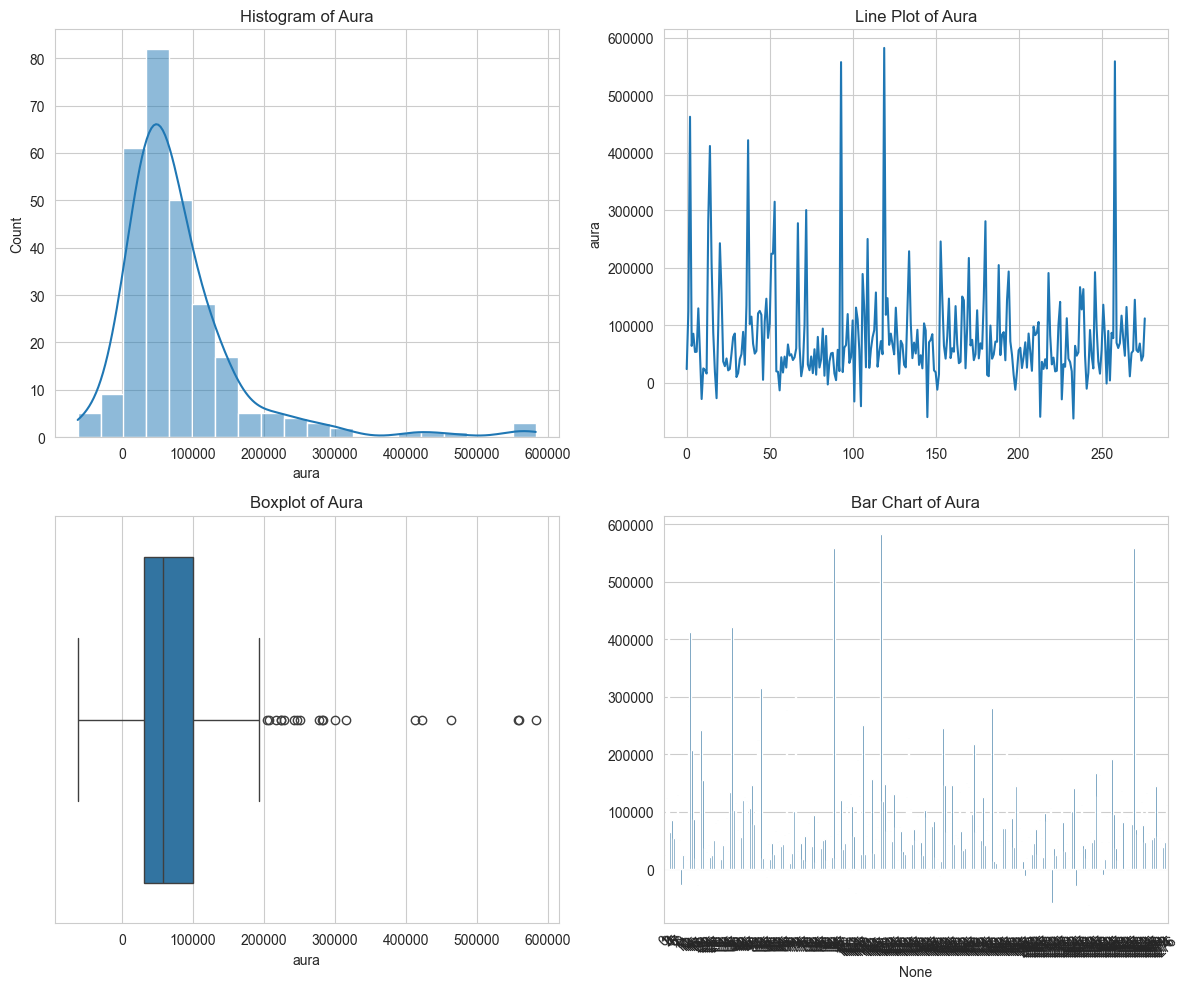

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming user_stats_df['aura'] is already available in the user's environment
aura_data = user_stats_df['aura']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(aura_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=aura_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=aura_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if aura_data.dtype == 'object':
    sns.countplot(y=aura_data, ax=axes[1, 1])
else:
    sns.barplot(x=aura_data.index, y=aura_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [32]:
user_stats_df[['user', 'aura']].sort_values(by='aura').tail(50)

,user,aura
44,HansoloSupremo,125077.0
175,haHAA_12_btw,126127.0
133,catsspurr,126283.0
107,Wii_Gii,126779.0
238,shenxir,127641.0
7,55Dash,129491.0
126,blind_dood,130687.0
102,Vidke04,130797.5
265,xan_gny,131921.0
162,finskbamse,133414.5


In [33]:
print(user_stats_df[['user', 'bit']].sort_values(by='bit').tail(10))

                         user   bit
239                  shogalul   450
251              thebigdogjay   650
143                   damm1jp   650
3                    1SKELTON  1275
238                   shenxir  1275
14   Aluminiumminimumimmunity  1725
258                   uuccugr  1950
221                 rebbel576  2325
102                   Vidke04  2375
20                CrazeE420xd  2975


In [34]:
print(user_stats_df[['user', 'longest_streak']].sort_values(by='longest_streak').tail(50))

                         user  longest_streak
245              softarballtt              27
123                  bigabugj              27
141                cukululu41              27
219                  pige0n98              27
21                    Cuhhsin              27
218                 phrank007              28
270            ylb_cat_soul22              28
102                   Vidke04              29
169                giorgoslep              29
130              cake_for_me_              30
133                 catsspurr              30
109                   Zeololz              30
243                smilodon_j              32
154                   emad_c7              32
139                 cringeuss              34
212                   paaaat_              34
13                    Aloddin              34
117              astrologer95              35
106               Wanderer039              36
237          sercanwinchester              37
51                IvanOnMyOwn     

In [35]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_1'].unique()

# If you want to print them
print(unique_words)

['xqc32' 'the' 'ome44' 'is' 'you' 'speed1' 'FEET' 'FEIN' '1' 'NOWAYING'
 'ome99' 'omE' 'PepeLaugh' 'I' 'English' 'LUL' 'lul' 'druskiDance' 'a'
 'LOL' '!boost' 'i' 'loeyaKEKW' 'LULW' 'RaveTime' 'ReallyMad' 'Listening'
 'Smurfing' 'dome37' 'Sadge' '@dorozea' '?' 'mhm' 'u' 'Banger' 'bye'
 'OMEGALUL' 'erbyMariodance' 'hi' 'lol' 'doro' 'ICANT' 'BangbooBounce'
 'DORO' 'Yay' 'PewPewPew' 'dorozeaTouchingyou' 'forsenLaughingAtYou' 'YEP'
 'Clap' 'ome808' 'STREAMER' 'DinoDance' 'PagChomp' 'xd' 'LETSGO' 'WW'
 'forsenE' '!' 'dorozeaSlam' 'moustache' 'om' 'FROM' 'Joel' 'RalpherZ']


In [36]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_2'].unique()

# If you want to print them
print(unique_words)

['speed1' 'you' 'the' 'i' 'is' 'FEIN' '\U000e0000' 'u' 'FLASHBANG' 'ome32'
 'I' 'ome44' 'Tier' 'a' 'gg' 'LOL' 'DORO' 'Joel' 'bye' 'CaitThinking'
 'Only' 'LUL' 'Smurfing' 'nyanPls' 'OOOO' 'ratomilton' 'ICANT' 'omE' '?'
 'tuah!' 'DaRRa' 'catJAM' 'om' 'TITANHOLO' 'WatchingStream' '/' ':D'
 'erbyLuigidance' 'dorozeaSlam' 'GoldPLZ' '@Martin_Gales' 'yes' 'muted'
 'dorozeaHey' 'WideRaveTime' 'JinxLUL' 'it' 'TEAM' 'DinoDance' 'to' 'lol'
 'ome96' 'omEE' '!play' 'EZ' '😂😂😂' 'AlienPls3' 'Kappa' 'NO' '!boost'
 'ome52' 'OMEGALUL' 'doro' 'PepeLaugh' 'Banger' 'nt' 'WW' 'YEIN' 'ome5'
 'RUSSIA' 'qq' 'xan_gny' 'CHAT']


In [37]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_3'].unique()

# If you want to print them
print(unique_words)

['wideSpeedLaugh3' 'a' 'FEIN' 'you' 'hi' 'it' 'i' 'is' 'uuh' 'LOL' '16'
 'mhm' 'widetime' 'to' 'BANGER' 'buh' 'the' 'speed1' 'OOOO' 'ome44' 'LUL'
 'u' 'ome96' '?' '[warning]' 'AREYOUAGIRL' 'Cheer1000' 'xar2EDM'
 'arnoldHalt' 'qq' 'TEAM' 'o7' 'KEKW' '))' '\U000e0000' 'omE' 'yes'
 'PepeLaugh' 'PAUSENEMOGU' 'Who' 'bro' 'Joel' 'DORO' 'I' '@Martin_Gales'
 'xd' 'andrea540Doof' 'dorozeaAlert' 'SeemsGood' 'gg' 'OMEGALUL' 'om'
 'JARVIS' 'BloodTrail' 'Banger' 'Doro' 'OMEYES' 'she' 'DarkKnight' 'ome32'
 'DinoDance' 'ome5' 'WAJAJA' '@dorozea' '!play' 'yo' 'mikuPls' 'Headbang'
 'your' 'fein' 'hiii' 'FREE' 'MEGALUL' 'RAID' 'FeelsWowMan' 'doro'
 'paaaat_' 'peepoDJ' 'She' 'jah' 'on' 'Dorozea' 'IT' 'dorozeaSignOff'
 'ome99' 'WITH' 'Tier' 'NO']


In [38]:
user_stats_df[user_stats_df['user']=='balintboss']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,warn_count,bit,gifts,aura
119,balintboss,28706,116498,4.058315,103.631769,the,2170,you,2092,I,...,ready to 1984,2025-03-26 21:12:15+01:00,I ENJOYED MY STAY doroL I ENJOYED MY STAY doro...,0,"[1, 1, 1, 1, 1]","[LOL, 1351, dome32, 1113, o7, 789]",2,0,0.0,582591.0


In [39]:
user_stats_df[user_stats_df['user']=='Aluminiumminimumimmunity']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,warn_count,bit,gifts,aura
14,Aluminiumminimumimmunity,8662,27558,3.181482,32.935361,FEIN,4647,ome44,3237,widetime,...,lirikWavy,2025-03-26 21:12:27+01:00,bye bye,16773,"[1, 1, 1, 0, 0]","[ome44, 3237, widetime, 917, bye, 618]",12,1725,46.0,411988.0


In [40]:
user_stats_df[user_stats_df['user']=='Typhu25']


,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,warn_count,bit,gifts,aura
101,Typhu25,17227,287692,16.700064,83.626214,FEIN,136660,ome44,50397,speed1,...,!play,2025-03-26 20:07:59+01:00,Banger Banger Banger Banger Banger Banger Bang...,400,"[1, 1, 1, 1, 0]","[ome44, 50397, speed1, 5702, ome52, 1415]",1,0,0.0,-32511.0


In [41]:
user_stats_df.nlargest(10, 'word_per_message')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,warn_count,bit,gifts,aura
101,Typhu25,17227,287692,16.700064,83.626214,FEIN,136660,ome44,50397,speed1,...,!play,2025-03-26 20:07:59+01:00,Banger Banger Banger Banger Banger Banger Bang...,400,"[1, 1, 1, 1, 0]","[ome44, 50397, speed1, 5702, ome52, 1415]",1,0,0.0,-32511.0
93,StreamElements,26793,360379,13.450491,96.725632,the,18519,/,15843,to,...,dorozea is now live! Streaming Just Chatting: ...,2025-03-26 21:05:39+01:00,-Twitter: https://twitter.com/dorozeaxd -TikT...,0,"[1, 1, 1, 1, 1]","[WW, 2350, CS2, 856, mods, 663]",0,0,0.0,557899.0
9,ACEiCLE,675,6939,10.280000,135.000000,speed1,5998,󠀀,258,uuh,...,LOL,2025-03-20 22:01:10+01:00,!bedrooms,0,"[0, 0, 0, 0, 0]","[speed1, 5998, uuh, 85, !boost, 85]",0,0,0.0,-28222.0
15,AnAnonymousGifter,979,9792,10.002043,15.296875,1,983,Tier,979,to,...,An anonymous user gifted a Tier 1 sub to asd_u...,2025-03-23 16:12:20+01:00,An anonymous user gifted a Tier 3 sub to yddre...,0,"[1, 0, 0, 0, 0]",[],0,0,1351.0,207579.0
217,peroni_nasturo_azuro,1735,15745,9.074928,25.895522,a,569,you,496,the,...,roadhog is a british football fan he loves peroni,2024-10-20 19:04:01+02:00,@1206paul_ i refreshed and the code isnt in ch...,0,"[1, 0, 1, 0, 0]","[Pffttt, 31, ok, 19, life, 16]",0,0,0.0,24859.0
37,Fossabot,5251,47512,9.048181,25.866995,English,4975,Only,4975,[warning],...,"@BERAT612850, Blocked language detected [warning]",2025-03-26 20:34:26+01:00,"@blin4ik_18, English Only In Chat so mods can ...",0,"[1, 1, 1, 1, 1]","[mods, 3647, Chatting, 29, Joel, 2]",0,0,0.0,422031.0
176,hanepirukas1,1216,10661,8.767270,33.777778,YEP,273,is,258,the,...,"Dogs sniff eachothers ass, what would human eq...",2024-10-03 17:35:58+02:00,(fart),300,"[1, 0, 0, 0, 0]","[YEP, 273, Hmm, 90, NODDERS, 43]",0,0,0.0,42435.0
131,captainmark2024,758,6476,8.543536,42.111111,the,168,you,142,is,...,"Hello dorozea, my best friend ever",2025-03-15 16:40:06+01:00,trump: Doro must play for 10K in CS or it will...,0,"[0, 0, 0, 0, 0]","[ok, 5, life, 5, hi, 4]",0,0,0.0,31158.0
161,fcukboii,946,7578,8.010571,21.022222,PewPewPew,470,DinoDance,413,DarkKnight,...,How old are you?!,2025-03-26 21:12:21+01:00,No BigSad BigSad BigSad BigSad BigSad,0,"[0, 1, 0, 0, 0]","[!play, 6, Paul, 4, bye, 4]",2,0,0.0,54034.0
171,greekviewer1,2355,18082,7.678132,28.719512,forsenLaughingAtYou,795,speed1,748,WAJAJA,...,@dorozea Good evening Ma'am,2025-03-25 20:37:38+01:00,@dorozea I think in this mission the black one...,0,"[0, 1, 0, 0, 0]","[forsenLaughingAtYou, 795, speed1, 748, WAJAJA...",2,0,0.0,65004.0


In [42]:
user_stats_df.nlargest(10, 'total_streams')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,warn_count,bit,gifts,aura
93,StreamElements,26793,360379,13.450491,96.725632,the,18519,/,15843,to,...,dorozea is now live! Streaming Just Chatting: ...,2025-03-26 21:05:39+01:00,-Twitter: https://twitter.com/dorozeaxd -TikT...,0,"[1, 1, 1, 1, 1]","[WW, 2350, CS2, 856, mods, 663]",0,0,0.0,557899.0
119,balintboss,28706,116498,4.058315,103.631769,the,2170,you,2092,I,...,ready to 1984,2025-03-26 21:12:15+01:00,I ENJOYED MY STAY doroL I ENJOYED MY STAY doro...,0,"[1, 1, 1, 1, 1]","[LOL, 1351, dome32, 1113, o7, 789]",2,0,0.0,582591.0
2,1206paul_,20860,110845,5.313758,77.835821,ome44,3980,the,2619,FEIN,...,go and find some friends ICANT,2025-03-26 21:01:57+01:00,AwHellNah,200,"[1, 1, 1, 1, 0]","[ome44, 3980, LETSGO, 995, WW, 693]",0,0,1.0,462839.0
14,Aluminiumminimumimmunity,8662,27558,3.181482,32.935361,FEIN,4647,ome44,3237,widetime,...,lirikWavy,2025-03-26 21:12:27+01:00,bye bye,16773,"[1, 1, 1, 0, 0]","[ome44, 3237, widetime, 917, bye, 618]",12,1725,46.0,411988.0
120,banties_x,29871,123645,4.139299,118.535714,speed1,8710,FEIN,7147,ome44,...,Yooo,2025-03-26 21:12:34+01:00,Smile,10,"[1, 1, 1, 1, 1]","[speed1, 8710, ome44, 6347, widetime, 2880]",0,0,1.0,118282.0
67,Martin_Gales,41510,246074,5.928066,169.428571,FEIN,17658,ome44,7049,the,...,hi there,2025-03-24 20:10:20+01:00,better than the other porsche,526,"[1, 1, 1, 0, 0]","[ome44, 7049, gg, 4538, mhm, 3384]",0,0,0.0,277649.0
13,Aloddin,5939,34455,5.801482,24.340164,FEET,1082,I,1012,mhm,...,yup,2025-03-26 18:19:01+01:00,Yo,10,"[1, 1, 0, 1, 1]","[mhm, 829, o7, 240, GIGACHAIR, 232]",0,0,0.0,282940.0
72,Nightbot,2093,14125,6.748686,8.720833,is,698,tuah!,426,Who,...,Submit your setups in the #rate-my-setup text ...,2025-03-26 19:52:29+01:00,check the qna for specs -> https://youtu.be/bK...,0,"[1, 1, 0, 1, 0]","[BUSSERS, 5]",0,0,0.0,300495.0
193,klimzaa,19151,119546,6.242285,82.904762,ome44,12246,ome52,8111,fein,...,!video,2025-03-26 18:08:12+01:00,o7,0,"[1, 1, 1, 1, 0]","[ome44, 12246, ome52, 8111, fein, 7667]",0,0,0.0,143889.0
109,Zeololz,4303,19430,4.515454,19.829493,u,471,i,392,the,...,fuck valorant Smile,2025-03-26 18:02:29+01:00,btw wtf is this mug name,0,"[1, 1, 1, 1, 0]","[aga, 184, Smile, 142, omE, 118]",3,0,0.0,250241.0


In [43]:
user_stats_df['total_streams'].describe()

count    277.000000
mean      65.028881
std       55.771914
min        3.000000
25%       27.000000
50%       49.000000
75%       83.000000
max      277.000000
Name: total_streams, dtype: float64

In [44]:
user_stats_df.sort_values(by='last_message_date').head(25)

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,warn_count,bit,gifts,aura
208,nevadasieera,519,2234,4.304432,47.181818,the,44,to,42,FeelsWowMan,...,why she so cute chat?,2024-06-11 14:27:10+02:00,i called her friend and now she thinks she's n...,0,"[0, 0, 0, 0, 0]","[FeelsWowMan, 37, FeelsBadMan, 26, BibleThump,...",0,0,0.0,20819.0
197,lothric_tenz,580,3365,5.801724,82.857143,the,142,you,89,to,...,Hello! Is this your 1st Souls game ?,2024-06-17 19:58:58+02:00,"No worries, you will figure out a strat to bea...",0,"[0, 0, 0, 0, 0]","[LULW, 36, EZ, 26, ok, 15]",0,0,10.0,13624.0
267,xxxflower1,791,2945,3.723135,79.100000,?,62,the,56,you,...,first try btw,2024-06-24 14:30:32+02:00,alright,0,"[0, 0, 0, 0, 0]","[OMEGALUL, 47, !play, 24, PepeLaugh, 22]",0,0,0.0,11241.0
83,RealDrLing,661,2509,3.795764,73.444444,the,81,LUL,64,to,...,RealDrLing subscribed at Tier 1. They've subsc...,2024-06-24 21:14:23+02:00,bye,0,"[0, 0, 0, 0, 0]","[owoCheer, 42, OMEGALUL, 8, !play, 8]",0,0,10.0,12305.0
130,cake_for_me_,606,784,1.293729,16.833333,lol,52,yes,41,gg,...,rainbow 6 siege is like 21.05 eur,2024-07-13 19:08:40+02:00,hi,0,"[0, 0, 0, 0, 0]","[gg, 31, hi, 27, bye, 26]",0,0,0.0,66558.0
84,Risc__V,2908,10524,3.618982,48.466667,the,228,is,184,you,...,DIESOFCRINGE,2024-07-24 18:24:00+02:00,CLOWNDETECTED,0,"[0, 0, 0, 0, 0]","[classic, 156, YEP, 132, mhm, 66]",0,0,0.0,81546.0
92,SercanLeaxl,687,1578,2.296943,68.700000,the,58,WatchingStream,47,LOL,...,can u open the door,2024-08-01 15:48:36+02:00,#ad,0,"[0, 0, 0, 0, 0]","[WatchingStream, 47, LOL, 36, !play, 12]",1,0,0.0,20295.0
179,icep1cke,1389,2282,1.642909,17.362500,Clap,295,EZ,120,!play,...,peepoClap,2024-08-09 20:48:43+02:00,!play 󠀀,100,"[0, 0, 0, 0, 0]","[Clap, 295, EZ, 120, !play, 102]",0,0,10.0,147843.0
231,saadr223,678,3342,4.929204,23.379310,you,123,the,109,bro,...,scripted game,2024-08-22 14:55:02+02:00,bro we use water,0,"[0, 0, 0, 0, 0]","[arthur, 5, life, 3, gg, 2]",0,0,0.0,36074.0
99,TriplesingleJ,706,2751,3.896601,20.171429,is,107,you,77,to,...,lol,2024-08-27 19:10:21+02:00,bye,0,"[0, 0, 0, 0, 0]","[WW, 28, !play, 20, OMEGALUL, 9]",0,0,0.0,44656.0


In [45]:
user_stats_df['buster_usage'].describe()

count    277.000000
mean       0.498195
std        1.701714
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000
Name: buster_usage, dtype: float64

In [46]:
user_stats_df[['user', 'cheer']].sort_values(by='cheer').tail(50)

,user,cheer
90,SchiKen44,0
86,S4SK____,0
91,SeeMeNoMore_,0
34,Eyght,10
26,Dmoz1,10
239,shogalul,10
13,Aloddin,10
120,banties_x,10
187,kecso1g,10
62,Leftybrasco,10


In [47]:
user_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype                        
---  ------                    --------------  -----                        
 0   user                      277 non-null    object                       
 1   total_messages            277 non-null    int64                        
 2   total_words               277 non-null    int64                        
 3   word_per_message          277 non-null    float64                      
 4   avg_message_per_stream    277 non-null    float64                      
 5   most_common_word_1        277 non-null    object                       
 6   most_common_word_1_count  277 non-null    int64                        
 7   most_common_word_2        277 non-null    object                       
 8   most_common_word_2_count  277 non-null    int64                        
 9   most_common_word_3        277 non-null    o

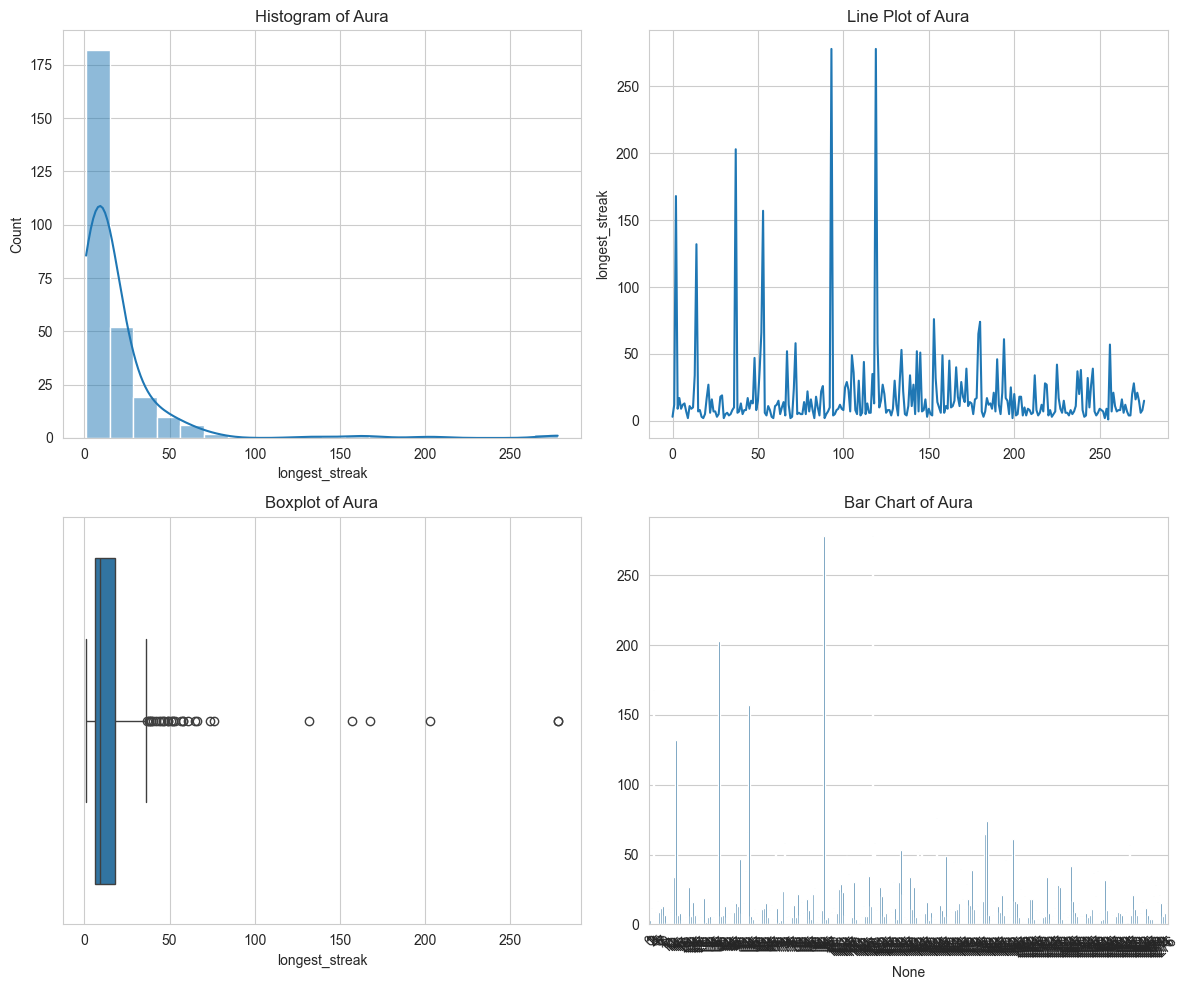

In [48]:

# Assuming user_stats_df['aura'] is already available in the user's environment
longest_streak_data = user_stats_df['longest_streak']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(longest_streak_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=longest_streak_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=longest_streak_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if longest_streak_data.dtype == 'object':
    sns.countplot(y=longest_streak_data, ax=axes[1, 1])
else:
    sns.barplot(x=longest_streak_data.index, y=longest_streak_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


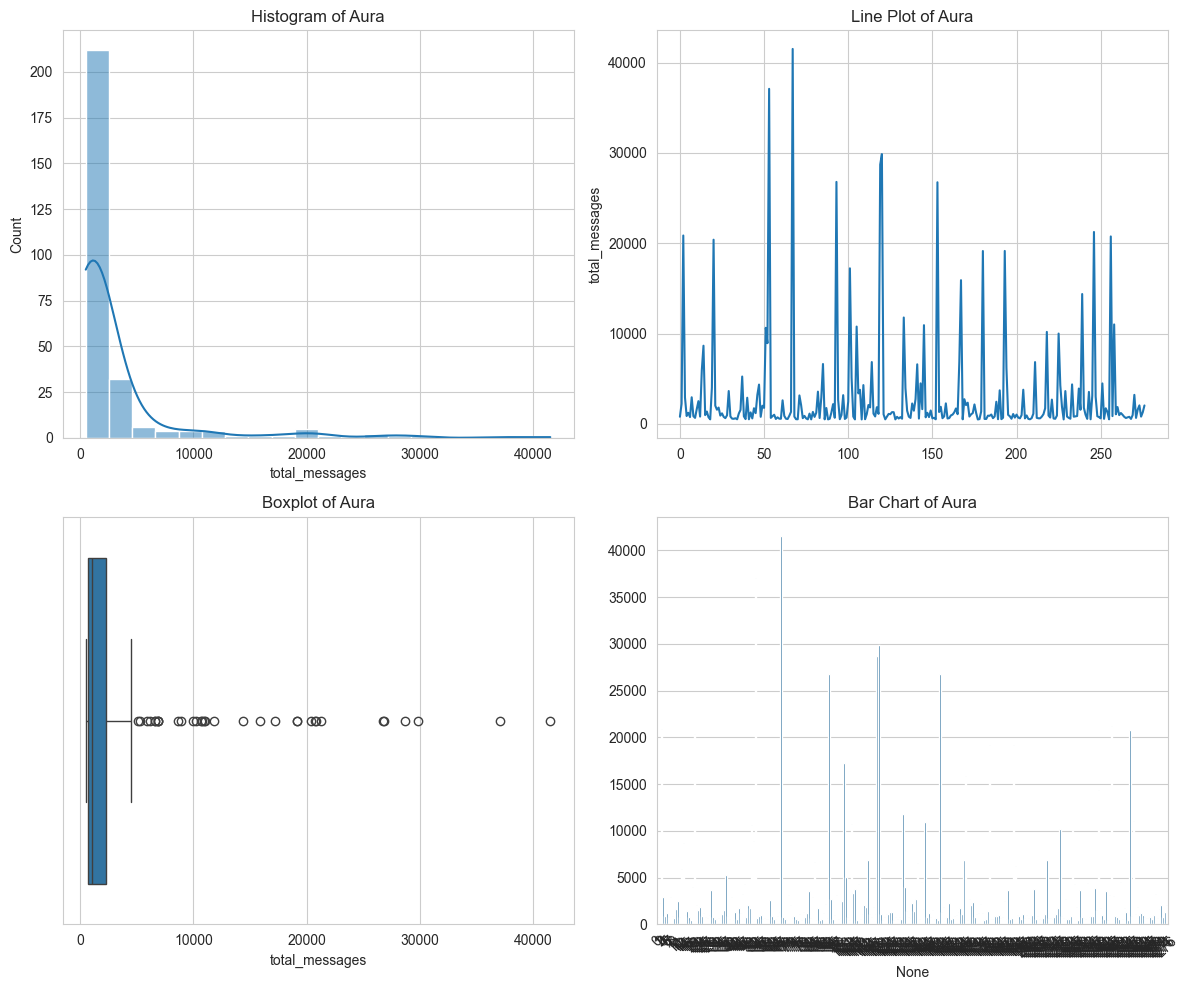

In [49]:

# Assuming user_stats_df['aura'] is already available in the user's environment
total_streams = user_stats_df['total_messages']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(total_streams, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=total_streams, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=total_streams, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if total_streams.dtype == 'object':
    sns.countplot(y=total_streams, ax=axes[1, 1])
else:
    sns.barplot(x=total_streams.index, y=total_streams.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [50]:
user_stats_df[['user', 'total_messages']].sort_values(by='total_messages').tail(50)

,user,total_messages
106,Wanderer039,3381
243,smilodon_j,3551
82,Ravenbtw,3578
229,roxa0,3642
29,Drizzie3S,3646
190,kindheadbanger,3723
107,Wii_Gii,3785
204,moondog357,3790
237,sercanwinchester,3920
134,chili_con_bacon,3965


In [51]:
user_stats_df['total_messages'].describe()

count      277.000000
mean      3010.454874
std       5695.246999
min        500.000000
25%        675.000000
50%       1039.000000
75%       2278.000000
max      41510.000000
Name: total_messages, dtype: float64

In [52]:
# Assuming user_stats_df is your DataFrame
def extract_unique_words(df, column="words_result"):
    # Extract elements at indices 0, 2, and 4 from each row
    selected_words = df[column].apply(lambda x: [x[0], x[2], x[4]] if len(x) > 4 else [])
    
    # Flatten the list and get unique words
    unique_words = list(set([word for sublist in selected_words for word in sublist]))
    
    return unique_words

# Example usage
unique_result = extract_unique_words(user_stats_df)
print(unique_result)

['Dorozea', 'MONKA', 'xar2EDM', 'uuh', 'AlienPls3', 'YEP', 'NOWAYING', 'gg', 'smh', 'Gayge', 'WidelebronJAM', 'Prayge', 'Banties', 'Enough', 'SCATTER', 'Smile', 'wideSpeedLaugh3', 'CS2', 'Listening', 'peepoDJ', 'dome32', 'classic', 'RaveDance', '!play', 'GOONING', 'AINTNOWAY', 'D:', 'ReallyMad', 'OOOO', '!boost', 'forsenPls', 'jah', 'WideRaveTime', 'TITANHOLO', 'EZ', 'arthur', 'HUH', 'MUGA', 'Paul', 'Fiddy', 'OMEGADANCE', 'Sadge', 'life', 'KEKW', 'monkaW', 'FeelsWowMan', 'ome96', 'eww', 'Sadding', 'PAUSENEMOGU', 'ohhh', 'VibePls', 'PagChomp', 'PagMan', 'LETSGO', 'nyanPls', 'Clap', 'bruv', 'Headbang', 'hesRight', 'GODDID', '!unfollow', 'speed1', 'bye', 'WAJAJA', 'paul', 'skip', 'HAH', 'hiii', 'Pffttt', 'MeWhenIBuyEgyptianProperty', 'peepoLove', 'Dentge', 'aga', 'hi', 'muted', 'omE', 'BibleThump', 'plinkVibe', ':0', 'ome32', 'buh', 'dome44', 'ok', 'Devious', 'Ohh', 'qq', 'widetime', 'ome18', 'nt', 'speed21', 'Shruge', 'MEGALUL', 'WW', 'catJAM', 'FLASHBANG', 'xdd', 'arnoldHalt', 'gkeywide

In [53]:
len(unique_result)

161

In [ ]:
# Method 1: Select specific columns by name
selected_columns = ['user','total_messages', 'aura', 'total_words','most_common_word_1','most_common_word_2','most_common_word_3','total_streams','longest_streak','first_message_date','first_message_text','last_message_date','last_message_text','achivments','words_result']
subset_df = user_stats_df[selected_columns]



In [55]:
# Export to json
#subset_df.to_json('usersdata.json', index=False)
subset_df.to_json("usersdata.json", orient="records", date_format="iso")